Chọn phương pháp biến đổi ảnh:
I - Image Inverse
G - Gamma Correction
L - Log Transformation
H - Histogram Equalization
C - Contrast Stretching
Đang xử lý ảnh: ha-long-bay-in-vietnam.jpg...


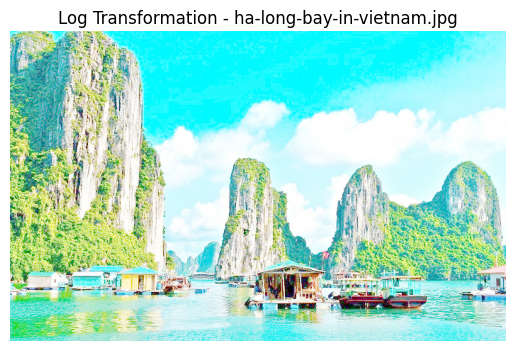

Đang xử lý ảnh: pagoda.jpg...


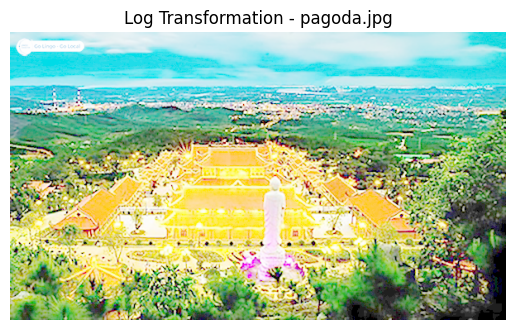

Đang xử lý ảnh: quang_ninh.jpg...


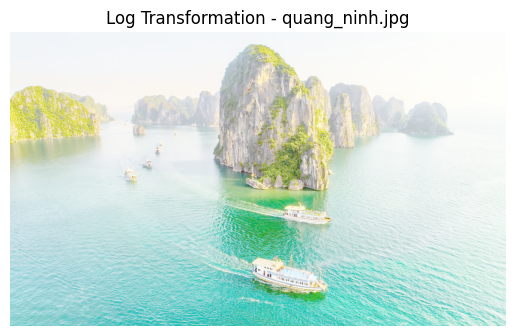

In [14]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Hàm áp dụng trên từng kênh màu
def apply_per_channel(img, func, **kwargs):
    result = np.zeros_like(img)
    for i in range(3):  # RGB
        if kwargs:
            result[..., i] = func(img[..., i], **kwargs)
        else:
            result[..., i] = func(img[..., i])
    return result

# Các hàm biến đổi ảnh
def inverse_image(img):
    return 255 - img

def gamma_correction(img, gamma=2.2):
    img = img / 255.0
    result = np.power(img, gamma)
    return np.uint8(result * 255)

def log_transformation(img):
    img = img.astype(float)
    max_val = np.max(img)
    if max_val == 0:
        return np.zeros_like(img, dtype=np.uint8)
    c = 255 / np.log(1 + max_val)
    result = c * np.log(1 + img)
    return np.clip(result, 0, 255).astype(np.uint8)

def histogram_equalization(img):
    hist, bins = np.histogram(img.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_norm = (cdf_masked - cdf_masked.min()) * 255 / (cdf_masked.max() - cdf_masked.min())
    cdf_final = np.ma.filled(cdf_norm, 0).astype('uint8')
    return cdf_final[img]

def contrast_stretching(img):
    a, b = np.min(img), np.max(img)
    stretched = 255 * (img - a) / (b - a)
    return np.uint8(stretched)

# Bản đồ chọn hàm
methods = {
    'I': ('Inverse', inverse_image),
    'G': ('Gamma Correction', gamma_correction),
    'L': ('Log Transformation', log_transformation),
    'H': ('Histogram Equalization', histogram_equalization),
    'C': ('Contrast Stretching', contrast_stretching)
}

# Menu chọn
print("Chọn phương pháp biến đổi ảnh:")
print("I - Image Inverse")
print("G - Gamma Correction")
print("L - Log Transformation")
print("H - Histogram Equalization")
print("C - Contrast Stretching")

choice = input("Nhập lựa chọn (I/G/L/H/C): ").upper()
if choice not in methods:
    print("Lựa chọn không hợp lệ.")
    exit()

method_name, method_function = methods[choice]

# Xử lý thư mục ảnh
input_folder = 'exercise'
output_folder = os.path.join(input_folder, 'output')
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.png')):
        input_path = os.path.join(input_folder, filename)
        print(f"Đang xử lý ảnh: {filename}...")

        img = Image.open(input_path).convert('RGB')
        img_np = np.array(img)

        if choice == 'G':
            result_np = apply_per_channel(img_np, method_function, gamma=2.2)
        else:
            result_np = apply_per_channel(img_np, method_function)

        output_path = os.path.join(output_folder, f'{choice}_{filename}')
        Image.fromarray(result_np).save(output_path)

        plt.imshow(result_np)
        plt.title(f"{method_name} - {filename}")
        plt.axis('off')
        plt.show()


Chọn phương pháp biến đổi ảnh:
F - Fast Fourier Transform
L - Butterworth Lowpass Filter
H - Butterworth Highpass Filter


▶ Đang xử lý ảnh: ha-long-bay-in-vietnam.jpg...


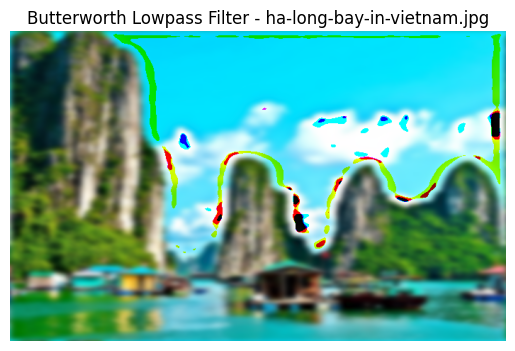

▶ Đang xử lý ảnh: pagoda.jpg...


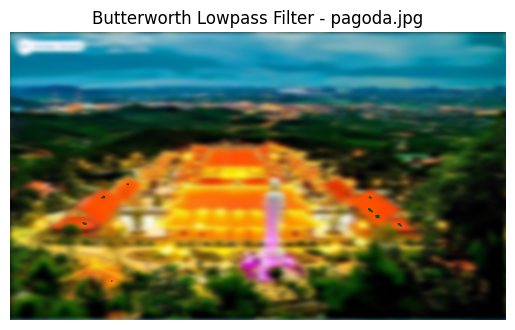

▶ Đang xử lý ảnh: quang_ninh.jpg...


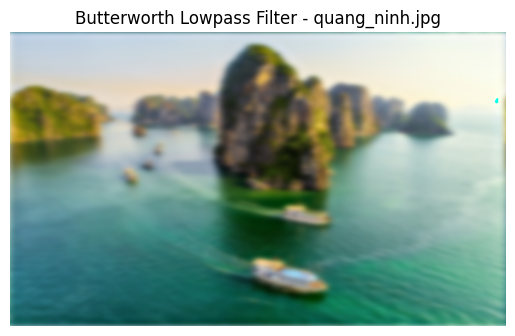

In [20]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Áp dụng biến đổi cho từng kênh RGB
def apply_per_channel(img, func, **kwargs):
    result = np.zeros_like(img)
    for i in range(3):  # R, G, B
        result[..., i] = func(img[..., i], **kwargs)
    return result

def fft_spectrum(channel):
    f = np.fft.fft2(channel)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(1 + np.abs(fshift))
    normalized = np.uint8(magnitude_spectrum / np.max(magnitude_spectrum) * 255)
    return normalized

def butterworth_lowpass(channel, cutoff=30, order=2):
    rows, cols = channel.shape
    crow, ccol = rows // 2 , cols // 2

    u = np.arange(rows)
    v = np.arange(cols)
    V, U = np.meshgrid(v, u)
    D = np.sqrt((U - crow)**2 + (V - ccol)**2)
    H = 1 / (1 + (D / cutoff)**(2 * order))

    F = np.fft.fft2(channel)
    Fshift = np.fft.fftshift(F)
    G = H * Fshift
    G_ishift = np.fft.ifftshift(G)
    img_back = np.fft.ifft2(G_ishift)
    return np.uint8(np.abs(img_back))

def butterworth_highpass(channel, cutoff=30, order=2):
    rows, cols = channel.shape
    crow, ccol = rows // 2 , cols // 2

    u = np.arange(rows)
    v = np.arange(cols)
    V, U = np.meshgrid(v, u)
    D = np.sqrt((U - crow)**2 + (V - ccol)**2)
    H = 1 / (1 + (cutoff / (D + 1e-5))**(2 * order))  # tránh chia 0

    F = np.fft.fft2(channel)
    Fshift = np.fft.fftshift(F)
    G = H * Fshift
    G_ishift = np.fft.ifftshift(G)
    img_back = np.fft.ifft2(G_ishift)
    return np.uint8(np.abs(img_back))

# Bản đồ lựa chọn
methods = {
    'F': ('Fast Fourier Spectrum', fft_spectrum),
    'L': ('Butterworth Lowpass Filter', butterworth_lowpass),
    'H': ('Butterworth Highpass Filter', butterworth_highpass)
}

print("Chọn phương pháp biến đổi ảnh:")
print("F - Fast Fourier Transform")
print("L - Butterworth Lowpass Filter")
print("H - Butterworth Highpass Filter")

try:
    choice = input("Nhập lựa chọn (F/L/H): ").strip().upper()
except:
    print("⚠️ Không thể nhập lựa chọn trong môi trường hiện tại. Dùng giá trị mặc định: 'F'")
    choice = 'F'  # hoặc bạn có thể đổi sang 'H', 'L' để test

if choice not in methods:
    print("❌ Lựa chọn không hợp lệ.")
    exit()

method_name, method_function = methods[choice]

# Thư mục ảnh
input_folder = 'exercise'
output_folder = os.path.join(input_folder, 'output_bai2')
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.png')):
        input_path = os.path.join(input_folder, filename)
        print(f"▶ Đang xử lý ảnh: {filename}...")

        img = Image.open(input_path).convert('RGB')
        img_np = np.array(img)

        # Áp dụng biến đổi trên từng kênh
        if choice in ['L', 'H']:
            result_np = apply_per_channel(img_np, method_function, cutoff=30, order=2)
        else:
            result_np = apply_per_channel(img_np, method_function)

        # Lưu kết quả
        output_path = os.path.join(output_folder, f'{choice}_{filename}')
        Image.fromarray(result_np).save(output_path)

        plt.imshow(result_np)
        plt.title(f"{method_name} - {filename}")
        plt.axis('off')
        plt.show()


▶ Xử lý ảnh: ha-long-bay-in-vietnam.jpg


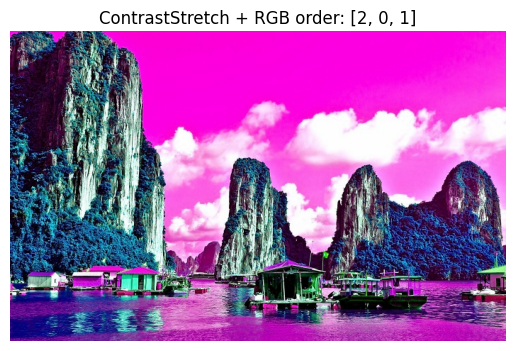

▶ Xử lý ảnh: pagoda.jpg


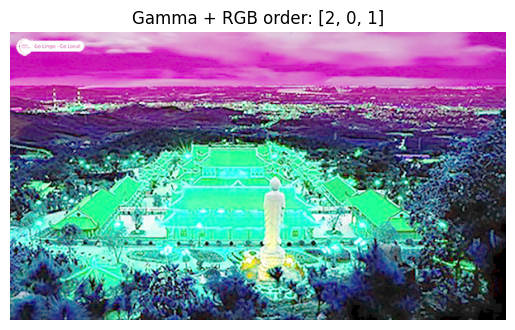

▶ Xử lý ảnh: quang_ninh.jpg


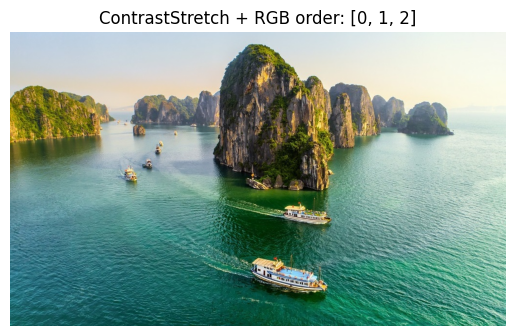

In [21]:
# Bài 3
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

# Các phép biến đổi ảnh áp dụng riêng từng kênh RGB
def inverse(img):
    return 255 - img

def gamma_correction(img, gamma=2.2):
    normalized = img / 255.0
    corrected = np.power(normalized, 1.0 / gamma)
    return np.uint8(corrected * 255)

def log_transform(img):
    img = img + 1  # tránh log(0)
    log_img = np.log(img)
    log_img = log_img / np.max(log_img) * 255
    return np.uint8(log_img)

def histogram_equalization(img):
    result = np.empty_like(img)
    for i in range(3):  # áp dụng từng kênh R, G, B
        hist, bins = np.histogram(img[:, :, i].flatten(), 256, [0,256])
        cdf = hist.cumsum()
        cdf = cdf * 255 / cdf[-1]
        result[:, :, i] = np.interp(img[:, :, i].flatten(), bins[:-1], cdf).reshape(img[:, :, i].shape)
    return np.uint8(result)

def contrast_stretching(img):
    stretched = np.empty_like(img)
    for i in range(3):
        min_val = np.min(img[:, :, i])
        max_val = np.max(img[:, :, i])
        stretched[:, :, i] = (img[:, :, i] - min_val) / (max_val - min_val + 1e-5) * 255
    return np.uint8(stretched)

# Danh sách các phép biến đổi
methods = [
    ('Inverse', inverse),
    ('Gamma', gamma_correction),
    ('Log', log_transform),
    ('HistogramEq', histogram_equalization),
    ('ContrastStretch', contrast_stretching)
]

# Đảo thứ tự RGB
def shuffle_rgb(img_rgb):
    img_array = np.array(img_rgb)
    channels = [0, 1, 2]
    random.shuffle(channels)
    shuffled = img_array[:, :, channels]
    return Image.fromarray(shuffled), channels

# Thư mục
input_folder = 'exercise'
output_folder = os.path.join(input_folder, 'output_bai3')
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.png')):
        print(f"▶ Xử lý ảnh: {filename}")

        img_path = os.path.join(input_folder, filename)
        img_rgb = Image.open(img_path).convert('RGB')
        shuffled_img, new_order = shuffle_rgb(img_rgb)
        img_array = np.array(shuffled_img)

        method_name, method_func = random.choice(methods)
        transformed = method_func(img_array)

        # Lưu và hiển thị
        output_path = os.path.join(output_folder, f"{method_name}_{filename}")
        Image.fromarray(transformed).save(output_path)

        plt.imshow(transformed)
        plt.title(f"{method_name} + RGB order: {new_order}")
        plt.axis('off')
        plt.show()


▶ Xử lý ảnh: ha-long-bay-in-vietnam.jpg


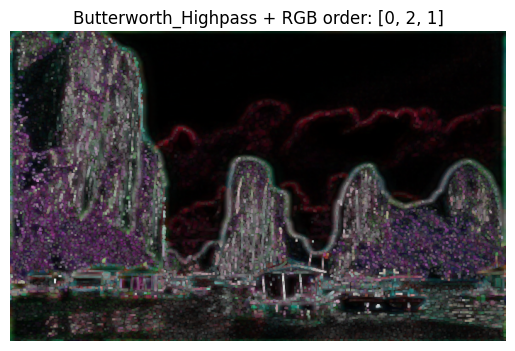

▶ Xử lý ảnh: pagoda.jpg


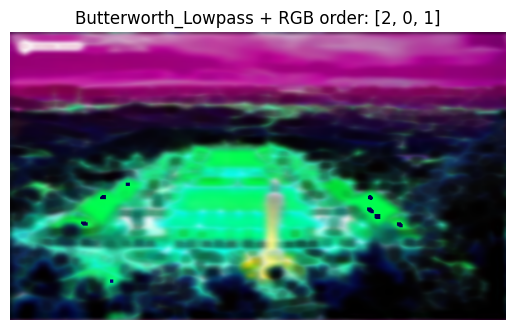

▶ Xử lý ảnh: quang_ninh.jpg


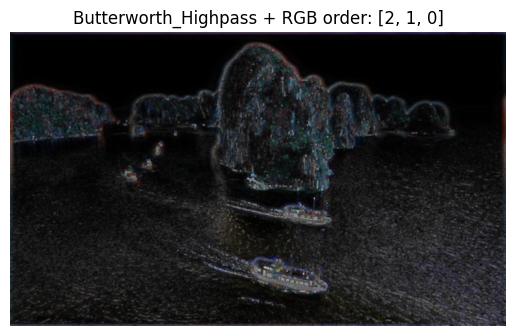

In [22]:
# Bài 4
import os
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import random

# Fast Fourier Transform cho từng kênh
def fast_fourier(img):
    result = np.empty_like(img)
    for i in range(3):
        f = np.fft.fft2(img[:, :, i])
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
        result[:, :, i] = magnitude_spectrum / np.max(magnitude_spectrum) * 255
    return np.uint8(result)

# Butterworth Lowpass Filter cho từng kênh
def butterworth_lowpass(img, d0=30, n=2):
    rows, cols = img.shape[:2]
    crow, ccol = rows // 2, cols // 2
    u, v = np.meshgrid(np.arange(cols), np.arange(rows))
    D = np.sqrt((u - ccol) ** 2 + (v - crow) ** 2)
    H = 1 / (1 + (D / d0) ** (2 * n))

    result = np.empty_like(img)
    for i in range(3):
        f = np.fft.fft2(img[:, :, i])
        fshift = np.fft.fftshift(f)
        filtered = fshift * H
        ishift = np.fft.ifftshift(filtered)
        img_back = np.fft.ifft2(ishift)
        result[:, :, i] = np.abs(img_back)
    return np.uint8(result)

# Butterworth Highpass Filter cho từng kênh
def butterworth_highpass(img, d0=30, n=2):
    rows, cols = img.shape[:2]
    crow, ccol = rows // 2, cols // 2
    u, v = np.meshgrid(np.arange(cols), np.arange(rows))
    D = np.sqrt((u - ccol) ** 2 + (v - crow) ** 2)
    H = 1 / (1 + (d0 / (D + 1e-5)) ** (2 * n))

    result = np.empty_like(img)
    for i in range(3):
        f = np.fft.fft2(img[:, :, i])
        fshift = np.fft.fftshift(f)
        filtered = fshift * H
        ishift = np.fft.ifftshift(filtered)
        img_back = np.fft.ifft2(ishift)
        result[:, :, i] = np.abs(img_back)
    return np.uint8(result)

# Đảo kênh màu RGB
def shuffle_rgb(img_rgb):
    arr = np.array(img_rgb)
    order = [0, 1, 2]
    random.shuffle(order)
    return Image.fromarray(arr[:, :, order]), order

# Thư mục ảnh
input_folder = 'exercise'
output_folder = os.path.join(input_folder, 'output_bai4')
os.makedirs(output_folder, exist_ok=True)

# Danh sách phép biến đổi
methods = [
    ('Fourier', fast_fourier),
    ('Butterworth_Lowpass', butterworth_lowpass),
    ('Butterworth_Highpass', butterworth_highpass)
]

# Xử lý từng ảnh
for filename in os.listdir(input_folder):
    if filename.lower().endswith(('.jpg', '.png')):
        print(f"▶ Xử lý ảnh: {filename}")
        img_path = os.path.join(input_folder, filename)
        img_rgb = Image.open(img_path).convert('RGB')

        # Đảo kênh màu RGB
        shuffled_img, rgb_order = shuffle_rgb(img_rgb)
        img_array = np.array(shuffled_img)

        # Chọn phương pháp ngẫu nhiên
        method_name, method_func = random.choice(methods)
        transformed = method_func(img_array)

        # Áp dụng Min hoặc Max Filter nếu là Butterworth
        result_img = Image.fromarray(transformed)
        if method_name == 'Butterworth_Lowpass':
            result_img = result_img.filter(ImageFilter.MinFilter(3))
        elif method_name == 'Butterworth_Highpass':
            result_img = result_img.filter(ImageFilter.MaxFilter(3))

        # Lưu và hiển thị
        output_path = os.path.join(output_folder, f"{method_name}_{filename}")
        result_img.save(output_path)

        plt.imshow(result_img)
        plt.title(f"{method_name} + RGB order: {rgb_order}")
        plt.axis('off')
        plt.show()
